In [1]:
# import os

# # 设置环境变量
# os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# # 打印环境变量以确认设置成功
# print(os.environ.get('HF_ENDPOINT'))

import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
import os
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # 使用 notebook 专用的进度条，更好看
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 让图表直接在 Jupyter 中显示
%matplotlib inline

# =================配置区域=================
# 请确保这个路径是相对于你当前 ipynb 文件的正确路径
# 如果你的 notebook 和 best_model_seed_98 文件夹在同一级目录，这样写就行
MODEL_PATH = "./best_model_seed_56"  
SEED = 56
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# =========================================

Using device: cuda


In [3]:
#!pip install -q seaborn

In [4]:
# 1. 加载模型和分词器
print(f">>> Loading model from {MODEL_PATH}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=2)
    model.to(device)
    model.eval()
    print("✅ Model loaded successfully!")
except OSError:
    print(f"❌ Error: 找不到路径 {MODEL_PATH}。请检查文件夹是否存在，或者使用绝对路径。")

# 2. 准备数据
print(">>> Loading Test Dataset (Protein short)...")
# 加载测试集
dataset = load_dataset('dnagpt/biopaws', 'protein_pair_short')['train'].train_test_split(test_size=0.3, seed=SEED)["test"]

# 数据预处理函数
def tokenize_function(example):
    return tokenizer(
        example["sentence1"], 
        example["sentence2"], 
        truncation=True,
        max_length=256, 
        padding="max_length"
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print(f"✅ Dataset loaded: {len(tokenized_dataset)} samples")

>>> Loading model from ./best_model_seed_56...
✅ Model loaded successfully!
>>> Loading Test Dataset (Protein 450bp)...


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

✅ Dataset loaded: 6000 samples


In [5]:
dataset

Dataset({
    features: ['sentence1', 'sentence2', 'label'],
    num_rows: 6000
})

In [6]:
def extract_all_layers(model, dataset):
    from torch.utils.data import DataLoader
    
    # 存储每一层的特征: Key=LayerIndex, Value=List of vectors
    # GPT-2 Small 有 12 层 transformer + 1 层 embedding = 13层
    layer_features = {i: [] for i in range(model.config.n_layer + 1)} 
    labels = []
    
    dataloader = DataLoader(
        dataset.remove_columns([c for c in dataset.column_names if c not in ['input_ids', 'attention_mask', 'label']]),
        batch_size=BATCH_SIZE, 
        collate_fn=data_collator
    )
    
    print(">>> Extracting Hidden States from all layers...")
    for batch in tqdm(dataloader, desc="Extracting"):
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        batch_labels = batch['labels'].cpu().numpy()
        labels.extend(batch_labels)
        
        with torch.no_grad():
            # output_hidden_states=True 是关键
            outputs = model(**inputs, output_hidden_states=True)
            all_layers = outputs.hidden_states 
            
            # 获取最后一个有效 token 的位置 (EOS token position)
            last_token_indices = inputs['attention_mask'].sum(1) - 1
            
            for layer_idx, layer_tensor in enumerate(all_layers):
                # 提取序列特征
                pooled_output = layer_tensor[torch.arange(layer_tensor.shape[0], device=device), last_token_indices, :]
                layer_features[layer_idx].append(pooled_output.cpu().numpy())
                
    # 合并数组
    for k in layer_features:
        layer_features[k] = np.concatenate(layer_features[k], axis=0)
        
    return layer_features, np.array(labels)

# 执行提取
features_dict, y_true = extract_all_layers(model, tokenized_dataset)
print("✅ Features extracted.")

>>> Extracting Hidden States from all layers...


Extracting:   0%|          | 0/188 [00:00<?, ?it/s]

✅ Features extracted.


>>> Training Linear Probes per layer...


Probing Layers:   0%|          | 0/13 [00:00<?, ?it/s]

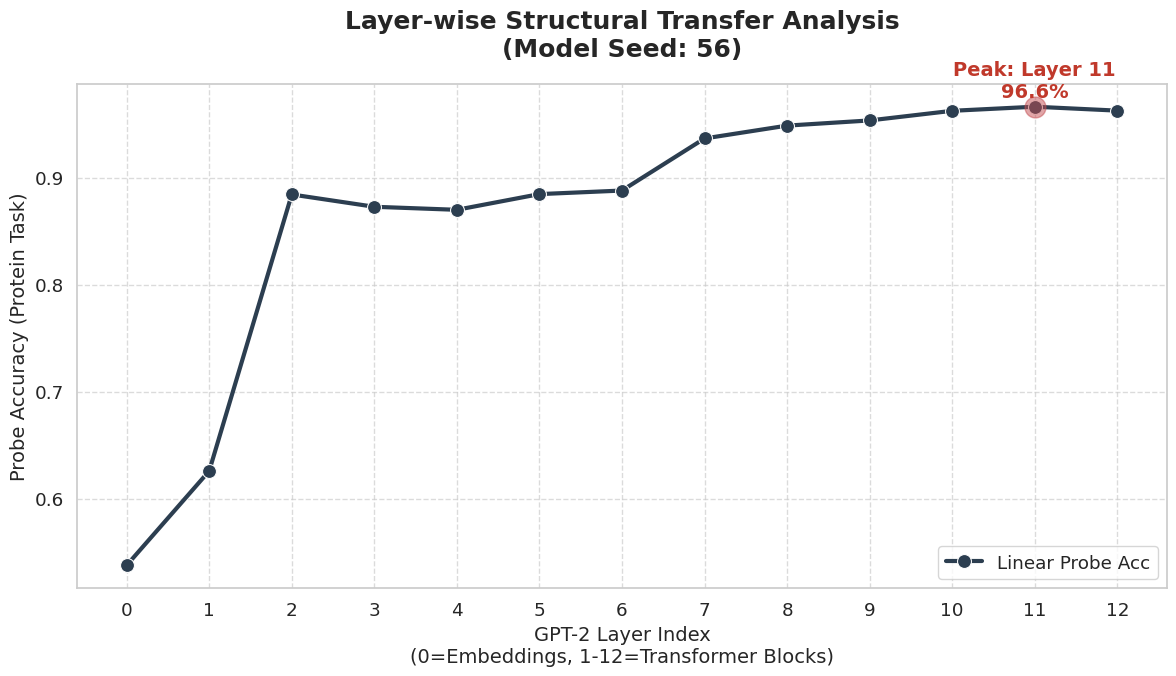


[Result Summary]
------------------------------
Layer 00: 0.5377
Layer 01: 0.6258
Layer 02: 0.8842
Layer 03: 0.8727
Layer 04: 0.8698
Layer 05: 0.8845
Layer 06: 0.8878
Layer 07: 0.9365
Layer 08: 0.9485
Layer 09: 0.9533
Layer 10: 0.9623
Layer 11: 0.9662
Layer 12: 0.9625


In [7]:
# 4. 逐层训练线性探针 (Linear Probe)
layer_accuracies = []
layers = sorted(features_dict.keys())

print(">>> Training Linear Probes per layer...")
# 使用 tqdm 显示训练进度
for layer_idx in tqdm(layers, desc="Probing Layers"):
    X = features_dict[layer_idx]
    y = y_true
    
    # 使用逻辑回归
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced'))
    
    # 3折交叉验证
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    avg_acc = scores.mean()
    layer_accuracies.append(avg_acc)

# 5. 绘图
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid", font_scale=1.2)

# 画主线
sns.lineplot(x=layers, y=layer_accuracies, marker="o", markersize=10, linewidth=3, color="#2c3e50", label="Linear Probe Acc")

# 标注最大值
max_acc = max(layer_accuracies)
max_layer = layers[layer_accuracies.index(max_acc)]

# 在最高点画个红圈
plt.plot(max_layer, max_acc, 'ro', markersize=15, alpha=0.5)
plt.text(max_layer, max_acc + 0.005, f"Peak: Layer {max_layer}\n{max_acc:.1%}", 
         ha='center', va='bottom', color='#c0392b', fontweight='bold', fontsize=14)

# 装饰图表
plt.title(f"Layer-wise Structural Transfer Analysis\n(Model Seed: {SEED})", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("GPT-2 Layer Index\n(0=Embeddings, 1-12=Transformer Blocks)", fontsize=14)
plt.ylabel("Probe Accuracy (Protein Task)", fontsize=14)
plt.xticks(layers)
plt.grid(True, linestyle='--', alpha=0.7)

# 添加区域解释（可选，根据你的结果调整位置）
# plt.axvspan(4.5, 8.5, color='#f1c40f', alpha=0.1, label='Syntactic Middle Layers')

plt.legend(loc='lower right')
plt.tight_layout()

plt.savefig("explain1.png")
# 直接显示
plt.show()

# 打印文本结果
print("\n[Result Summary]")
print("-" * 30)
for l, acc in zip(layers, layer_accuracies):
    print(f"Layer {l:02d}: {acc:.4f}")